In [1]:
# @title 1. Environment Setup (Run Once)
import os
import sys

from google.colab import drive
drive.mount('/content/drive')

# 1. Clone the main repository
#%cd /content/drive/MyDrive/Ricerca/latent-diffusion



# 2. Clone the Taming Transformers dependency
# (The LDM autoencoder relies on this repo for the VQGAN/VAE parts)
if not os.path.exists('taming-transformers'):
    !git clone https://github.com/CompVis/taming-transformers.git

# 3. Clone CLIP (Required for text encoders)
if not os.path.exists('CLIP'):
    !git clone https://github.com/openai/CLIP.git

# 4. Install Dependencies via Pip (Ignoring Conda)
# We install taming-transformers and the main repo in 'editable' mode (-e)
# so python can find the modules without complex path handling.
!pip install -q omegaconf einops transformers kornia imageio imageio-ffmpeg
!pip install pytorch-lightning==1.4.2 torchmetrics==0.6.0
!pip install -e ./taming-transformers
!pip install -e "/content/drive/MyDrive/Ricerca/latent-diffusion"
!pip install -q pandas
!pip install git+https://github.com/openai/CLIP.git
#!pip install -e ./CLIP

# 5. Fix Python Path
# This ensures that imports like `from ldm.models...` work correctly
sys.path.append(os.path.abspath('latent-diffusion'))
sys.path.append(os.path.abspath('taming-transformers'))

print("Environment setup complete. You can now run the training script.")

Mounted at /content/drive
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1342 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 2)
Receiving objects: 100% (1342/1342), 409.77 MiB | 14.78 MiB/s, done.
Resolving deltas: 100% (282/282), done.
Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256 (from 1)
Receiving objects: 100% (256/256), 8.93 MiB | 9.85 MiB/s, done.
Resolving deltas: 100% (133/133), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.6/916.6 kB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 kB 35.3 MB/s eta 0:00:00
Obtaining file:///content/taming-transformers
  Preparing metadata (setup.py) ... done
  Running setup.py de

In [2]:
%cd /content/drive/MyDrive/Ricerca/latent-diffusion

/content/drive/MyDrive/Ricerca/latent-diffusion


In [3]:
import torch.utils.checkpoint
import ldm.modules.diffusionmodules.util

def fixed_checkpoint(func, inputs, params, flag):
    """
    A patched checkpoint function that uses the modern torch.utils.checkpoint.
    This fixes the AMP (Half/Float) error by correctly preserving the Autocast state.
    """
    if flag:
        # 1. Unpack inputs
        input_list = list(inputs)

        # 2. Workaround for LoRA:
        # torch.checkpoint only runs backward if at least one INPUT requires grad.
        # Since our inputs might be frozen (coming from frozen layers),
        # we force the first tensor to require grad so the LoRA weights inside 'func' get trained.
        has_grad = any(x.requires_grad for x in input_list if isinstance(x, torch.Tensor))
        if not has_grad:
             for i, x in enumerate(input_list):
                 if isinstance(x, torch.Tensor) and x.is_floating_point():
                     input_list[i] = x.detach().requires_grad_(True)
                     break

        # 3. Use standard PyTorch checkpointing
        return torch.utils.checkpoint.checkpoint(func, *input_list, use_reentrant=True)
    else:
        # Gradient checkpointing disabled
        return func(*inputs)

# Apply the Monkey Patch
ldm.modules.diffusionmodules.util.checkpoint = fixed_checkpoint
print("Global patch applied: Gradient Checkpointing is now AMP-safe.")

Global patch applied: Gradient Checkpointing is now AMP-safe.


In [4]:
# Example Usage in Colab
from lora_train import train_lora_native

!wget https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt -O /content/model.ckpt

!wget https://raw.githubusercontent.com/CompVis/stable-diffusion/main/configs/stable-diffusion/v1-inference.yaml -O /content/v1-inference.yaml

import ldm.modules.encoders.modules

# The Stable Diffusion config looks for 'FrozenCLIPEmbedder'
# The Latent Diffusion repo calls it 'FrozenCLIPTextEmbedder'
# We map the old name to the new name here:
ldm.modules.encoders.modules.FrozenCLIPEmbedder = ldm.modules.encoders.modules.FrozenCLIPTextEmbedder

print("Monkey patch applied: FrozenCLIPEmbedder is now aliased to FrozenCLIPTextEmbedder.")

# Adjust paths to where you uploaded files in Colab

Global patch updated: Now encodes images to latents AND handles text lists.
--2026-01-28 11:55:16--  https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt
Resolving huggingface.co (huggingface.co)... 13.35.202.34, 13.35.202.121, 13.35.202.40, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.34|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.gcp.cdn.hf.co/xet-bridge-us/63009e8b79c5ddbc6cf69877/fea194533efdfd8f94b292f5d0aaa0c7744ea3394677afbd9bbd686c950ce227?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sd-v1-4.ckpt%3B+filename%3D%22sd-v1-4.ckpt%22%3B&Expires=1769604916&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiRXBvY2hUaW1lIjoxNzY5NjA0OTE2fX0sIlJlc291cmNlIjoiaHR0cHM6Ly91cy5nY3AuY2RuLmhmLmNvL3hldC1icmlkZ2UtdXMvNjMwMDllOGI3OWM1ZGRiYzZjZjY5ODc3L2ZlYTE5NDUzM2VmZGZkOGY5NGIyOTJmNWQwYWFhMGM3NzQ0ZWEzMzk0Njc3YWZiZDliYmQ2ODZjOTUwY2UyMjdcXD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2

In [5]:
train_lora_native(
    config_path="/content/v1-inference.yaml",  # <--- CHANGED THIS
    ckpt_path="/content/model.ckpt",
    parquet_url="hf://datasets/huggan/few-shot-obama/data/train-00000-of-00001.parquet",
    batch_size=1,
    lr=1e-4,
    epochs=10
)

In [6]:
from google.colab import files

# This will trigger a browser download for the file
#files.download('lora_finetuned.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading model...
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


100%|████████████████████████████████████████| 890M/890M [00:08<00:00, 116MiB/s]


Loading LoRA...
Replacing layer: diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1
Number of theoretical 2560
Number of parameters in Linear:  2560
Number of theoretical 2560
Number of parameters in Linear:  2560
New Parameters theoretical: 88
Replacing layer: diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2
Number of theoretical 2560
Number of parameters in Linear:  2560
Number of theoretical 4352
Number of parameters in Linear:  4352
New Parameters theoretical: 88
Replacing layer: diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1
Number of theoretical 2560
Number of parameters in Linear:  2560
Number of theoretical 2560
Number of parameters in Linear:  2560
New Parameters theoretical: 88
Replacing layer: diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2
Number of theoretical 2560
Number of parameters in Linear:  2560
Number of theoretical 4352
Number of parameters in Linear:  4352
New Parameters theoretical: 88
Replacing layer: diffusion_model

DDIM Sampler: 100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


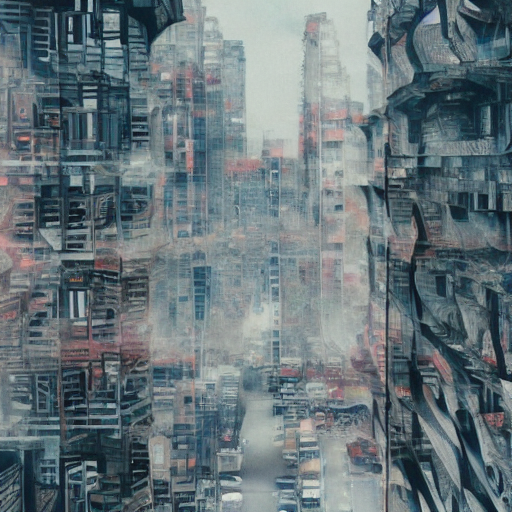

In [7]:
import torch
import numpy as np
from PIL import Image
from einops import rearrange
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from lora import loraModel, available_targets

def sample_with_lora(
    config_path="/content/v1-inference.yaml",
    base_ckpt_path="/content/model.ckpt",
    lora_ckpt_path="lora_finetuned.pt",
    prompt="a photo of Barack Obama",  # <--- MUST MATCH TRAINING PROMPT
    steps=50
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. Load Config & Model
    print("Loading model...")
    config = OmegaConf.load(config_path)
    model = instantiate_from_config(config.model)

    # 2. Patch CLIP
    import ldm.modules.encoders.modules
    ldm.modules.encoders.modules.FrozenCLIPEmbedder = ldm.modules.encoders.modules.FrozenCLIPTextEmbedder

    # 3. Load Base Weights
    pl_sd = torch.load(base_ckpt_path, map_location="cpu", weights_only=False)
    sd = pl_sd["state_dict"] if "state_dict" in pl_sd else pl_sd
    model.load_state_dict(sd, strict=False)

    # 4. Apply LoRA & Load Your Weights
    print("Loading LoRA...")
    model.model = loraModel(model.model, rank=4, targets=available_targets)
    lora_sd = torch.load(lora_ckpt_path, map_location="cpu", weights_only=False)
    model.model.load_state_dict(lora_sd, strict=False)

    model.to(device)
    model.eval()

    # 5. Sampler
    sampler = DDIMSampler(model)

    # 6. Generate Conditioning
    # unconditional (negative prompt)
    uc = model.get_learned_conditioning([""])
    # conditional (your prompt)
    c = model.get_learned_conditioning([prompt])

    # 7. Sample
    shape = [4, 512 // 8, 512 // 8]
    print(f"Sampling with prompt: '{prompt}'...")

    samples, _ = sampler.sample(
        S=steps,
        conditioning=c,
        batch_size=1,
        shape=shape,
        verbose=False,
        unconditional_guidance_scale=7.5, # Increased to force the prompt more
        unconditional_conditioning=uc,
        eta=0.0
    )

    # 8. Decode
    x_samples = model.decode_first_stage(samples)
    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

    # Display
    for x_sample in x_samples:
        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
        img = Image.fromarray(x_sample.astype(np.uint8))
        display(img)

sample_with_lora()